In [1]:
import random
import networkx as nx
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Bidirectional, Dropout, Activation,SimpleRNN ,LSTM , TimeDistributed,Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from keras.optimizers.legacy import Adam, RMSprop, SGD, Nadam,Adagrad
from keras.optimizers import AdamW
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, optimizers, activations
from node2vec import Node2Vec
from sklearn.metrics import average_precision_score

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TemporalRandomWalkSampler:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]


In [3]:
def extract_temporal_motifs(walks, motif_sizes):
    motifs = {}
    for size in motif_sizes:
        size_motifs = set()
        for walk in walks:
            for i in range(0, len(walk) - size * 2 + 1, 2):
                motif = tuple(walk[i:i + size * 2:2])
                size_motifs.add(motif)
        motifs[size] = size_motifs
    return motifs

def anonymize_motifs(motifs):
    node_encoder = OneHotEncoder()
    flattened_motifs = [str(node) for size in motifs for motif in motifs[size] for node in motif]
    node_encoder.fit(np.array(flattened_motifs).reshape(-1, 1))

    anonymized_motifs = {}
    for size, size_motifs in motifs.items():
        anonymized_size_motifs = set()
        for motif in size_motifs:
            encoded_motif = tuple(tuple(node_encoder.transform(np.array([[str(node)]]).reshape(-1, 1)).toarray().flatten()) for node in motif)
            anonymized_size_motifs.add(encoded_motif)
        anonymized_motifs[size] = anonymized_size_motifs

    return anonymized_motifs

def create_incidence_matrices(motifs):
    incidence_matrices = {}

    for size, size_motifs in motifs.items():
        vertices = set()
        hyperedges = []

        for motif in size_motifs:
            vertices.update(motif)
            hyperedges.append(motif)

        vertices = sorted(vertices)
        num_vertices = len(vertices)
        num_hyperedges = len(hyperedges)

        incidence_matrix = np.zeros((num_vertices, num_hyperedges))

        for j, hyperedge in enumerate(hyperedges):
            for vertex in hyperedge:
                i = vertices.index(vertex)
                incidence_matrix[i, j] = 1

        incidence_matrices[size] = (incidence_matrix, vertices, hyperedges)

    return incidence_matrices

def extract_node_features(temporal_network, incidence_matrices):
    node_features = {}

    for size, (incidence_matrix, vertices, hyperedges) in incidence_matrices.items():
        # Extract features from the incidence matrix for each node
        node_degree = incidence_matrix.sum(axis=1)  # Degree centrality
        node_closeness = np.reciprocal(incidence_matrix.sum(axis=1))  # Closeness centrality
        node_betweenness = np.sum(incidence_matrix, axis=1)  # Betweenness centrality

        # Combine the features into a feature matrix
        features = np.column_stack((node_degree, node_closeness, node_betweenness))

        # Store the features in a dictionary with node labels as keys
        node_features[size] = {node: feature for node, feature in zip(vertices, features)}

    # Extract Node2Vec embeddings
    node2vec = Node2Vec(temporal_network, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node2vec_features = {str(node): model.wv[str(node)] for node in temporal_network.nodes()}

    # Merge all features
    merged_features = {}
    for node in temporal_network.nodes():
        embedding_features = node2vec_features[str(node)]
        if node in node_features:
            basic_features = np.concatenate([features[node] for size, features in node_features.items() if node in features])
            merged_features[node] = np.concatenate((basic_features, embedding_features))
        else:
            merged_features[node] = embedding_features

    return merged_features

In [4]:
def prepare_link_prediction_data(temporal_network, node_features, train_size=0.7, val_size=0.15):
    positive_samples = []
    negative_samples = []

    nodes = list(temporal_network.nodes())

    # Create positive samples
    for edge in temporal_network.edges():
        source, target = edge
        if source in node_features and target in node_features:
            positive_samples.append((source, target, node_features[source], node_features[target], 1))

    # Create negative samples
    while len(negative_samples) < len(positive_samples):
        source, target = random.sample(nodes, 2)
        if not temporal_network.has_edge(source, target):
            if source in node_features and target in node_features:
                negative_samples.append((source, target, node_features[source], node_features[target], 0))

    samples = positive_samples + negative_samples
    random.shuffle(samples)

    # Check for inconsistent feature lengths
    max_len = max(len(s[2]) for s in samples)
    print(f"Maximum feature length: {max_len}")
    for s in samples:
        print(f"Feature lengths: {len(s[2])}, {len(s[3])}")

    # Pad or trim features to ensure uniform length
    X = np.array([np.concatenate((pad_or_trim(s[2], max_len), pad_or_trim(s[3], max_len))) for s in samples])
    y = np.array([s[4] for s in samples])
    edge_info = [(s[0], s[1]) for s in samples]

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training, validation, and testing sets using StratifiedShuffleSplit
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_size), random_state=42)

    for train_index, temp_index in stratified_split.split(X, y):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]
        edge_info_train, edge_info_temp = [edge_info[i] for i in train_index], [edge_info[i] for i in temp_index]

    # Further split the temp data into validation and test sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(val_size / (1 - train_size)), random_state=42)

    for val_index, test_index in stratified_split.split(X_temp, y_temp):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]
        edge_info_val, edge_info_test = [edge_info_temp[i] for i in val_index], [edge_info_temp[i] for i in test_index]

    return X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test


In [5]:
def pad_or_trim(array, length):
    if len(array) < length:
        return np.pad(array, (0, length - len(array)), 'constant')
    else:
        return array[:length]

In [6]:
# Print prediction results
def print_prediction_results(model, X_test, y_test, edge_info_test):
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)

    print("node1 | node2 | prediction interaction | true interaction")
    for i, (node1, node2) in enumerate(edge_info_test):
        pred_interaction = predicted_labels[i]
        true_interaction = y_test[i]
        print(f"{node1} | {node2} | {pred_interaction} | {true_interaction}")

<h1>Data : CollegeMsg</h1>

In [6]:
# Example usage
filename = 'Data/CollegeMsg.txt'  # Replace with your actual file path
temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=30, alpha=0.5)

In [7]:
# Sample temporal random walks for each node in the graph
node_sets = temporal_rw_sampler.sample_temporal_random_walks()

# Extract temporal motifs from the sampled walks
all_walks = [walk for walks in node_sets.values() for walk in walks]
motif_sizes = [3, 4, 5, 6]
extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)

# Create incidence matrices for each n-node motif type
incidence_matrices = create_incidence_matrices(extracted_motifs)

# Extract node features from the incidence matrices
node_features = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)

Computing transition probabilities: 100%|█████████████████████████████████████████| 1899/1899 [00:07<00:00, 240.86it/s]


<h3>RNN</h3>

In [8]:
# Prepare data for link prediction
X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test = prepare_link_prediction_data(
    temporal_rw_sampler.temporal_network, node_features
)

Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [9]:
X_train

array([[-0.9934142 ,  0.26486772,  1.0825757 , ..., -1.4443628 ,
         1.8267703 , -0.8244341 ],
       [-0.23898047,  0.22459604, -3.370177  , ..., -3.1117246 ,
        -2.3132286 , -0.22586747],
       [ 0.06354348, -1.1120547 , -0.6707612 , ...,  2.0824647 ,
        -1.0434214 ,  0.1770218 ],
       ...,
       [-0.98185545, -1.3826058 ,  0.37446007, ..., -0.01724913,
         0.40255263, -0.20671567],
       [ 1.1420522 ,  0.40340972, -0.4749134 , ...,  1.1110467 ,
         0.37715265,  1.9403235 ],
       [-0.28332993, -1.1564491 , -0.26979616, ..., -2.1826158 ,
         0.8255318 ,  0.88259333]], dtype=float32)

In [43]:
# Check the classes in each set
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_val:", np.unique(y_val))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1]
Unique classes in y_val: [0 1]
Unique classes in y_test: [0 1]


In [11]:
# Reshape the input data to 3D (samples, timesteps, input_dim)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [12]:
# Define the activation functions and optimizers for RNN
activation_functions_rnn = {
    'tanh': 'tanh',
    'relu': 'relu',
    'leaky_relu': LeakyReLU(alpha=0.01)
}
optimizers_rnn = {
    'adam': Adam(),
    'rmsprop': RMSprop(),
    'sgd': SGD(),
    'nadam': Nadam()
}

In [13]:
def build_rnn_model(input_shape, output_shape, activation, dropout_rate=0.5):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(128, activation=activation, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(SimpleRNN(128, activation=activation)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_shape, activation='sigmoid'))
    return model

In [16]:
# Train and evaluate the RNN model for each combination
results_rnn = []
histories_rnn = {}
roc_curves_rnn = {}
best_model_rnn = None
best_avg_score = -1

for activation_name, activation in activation_functions_rnn.items():
    for optimizer_name, optimizer in optimizers_rnn.items():
        model = build_rnn_model((X_train.shape[1], X_train.shape[2]), 1, activation)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
        
        y_pred = model.predict(X_test).ravel()
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes)
        recall = recall_score(y_test, y_pred_classes)
        f1 = f1_score(y_test, y_pred_classes)
        auc = roc_auc_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)

        print(f"Activation: {activation_name}, Optimizer: {optimizer_name}, AUC: {auc:.4f}, AP: {ap:.4f}")
        
        results_rnn.append({
            'Activation Function': activation_name,
            'Optimizer': optimizer_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'AP': ap,
            'History': history  # Added history to the results dictionary
        })
        histories_rnn[(activation_name, optimizer_name)] = history
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_curves_rnn[(activation_name, optimizer_name)] = (fpr, tpr, auc)

        # Check for the best model based on average of AUC and AP
        avg_score = np.mean([auc, ap])
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_model_rnn = (activation_name, optimizer_name)

# Print the best model
print(f"\nBest Model: Activation: {best_model_rnn[0]}, Optimizer: {best_model_rnn[1]}")

Epoch 1/100
606/606 [==============================] - 6s 5ms/step - loss: 0.6369 - accuracy: 0.6522 - auc: 0.7050 - val_loss: 0.5206 - val_accuracy: 0.7432 - val_auc: 0.8307
Epoch 2/100
606/606 [==============================] - 2s 4ms/step - loss: 0.5252 - accuracy: 0.7421 - auc: 0.8177 - val_loss: 0.4260 - val_accuracy: 0.8167 - val_auc: 0.8956
Epoch 3/100
606/606 [==============================] - 3s 5ms/step - loss: 0.4707 - accuracy: 0.7812 - auc: 0.8580 - val_loss: 0.3790 - val_accuracy: 0.8391 - val_auc: 0.9170
Epoch 4/100
606/606 [==============================] - 3s 5ms/step - loss: 0.4296 - accuracy: 0.8100 - auc: 0.8842 - val_loss: 0.3534 - val_accuracy: 0.8516 - val_auc: 0.9268
Epoch 5/100
606/606 [==============================] - 3s 5ms/step - loss: 0.4001 - accuracy: 0.8259 - auc: 0.8997 - val_loss: 0.3374 - val_accuracy: 0.8588 - val_auc: 0.9377
Epoch 6/100
606/606 [==============================] - 3s 5ms/step - loss: 0.3806 - accuracy: 0.8375 - auc: 0.9096 - val_loss

In [18]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results_rnn, columns=['Activation Function', 'Optimizer', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC','AP'])
results_df

Activation Function Optimizer  Accuracy  Precision    Recall  F1 Score  \
0                 tanh      adam  0.900530   0.864853  0.949422  0.905166   
1                 tanh   rmsprop  0.901252   0.865351  0.950385  0.905877   
2                 tanh       sgd  0.849952   0.793062  0.947013  0.863227   
3                 tanh     nadam  0.895713   0.864949  0.937861  0.899931   
4                 relu      adam  0.960983   0.951841  0.971098  0.961373   
5                 relu   rmsprop  0.951830   0.919499  0.990366  0.953618   
6                 relu       sgd  0.921243   0.864831  0.998555  0.926895   
7                 relu     nadam  0.957852   0.948984  0.967726  0.958264   
8           leaky_relu      adam  0.955925   0.946673  0.966281  0.956377   
9           leaky_relu   rmsprop  0.959778   0.944988  0.976397  0.960436   
10          leaky_relu       sgd  0.917871   0.859809  0.998555  0.924003   
11          leaky_relu     nadam  0.957370   0.952358  0.962909  0.957605   

         AUC        AP  
0   0.963283  0.957181  
1   0.958459  0.944346  
2   0.938455  0.933437  
3   0.962741  0.957518  
4   0.990982  0.989855  
5   0.991807  0.990103  
6   0.991957  0.990970  
7   0.991587  0.990535  
8   0.992004  0.991424  
9   0.989977  0.987138  
10  0.993065  0.992389  
11  0.990663  0.989547

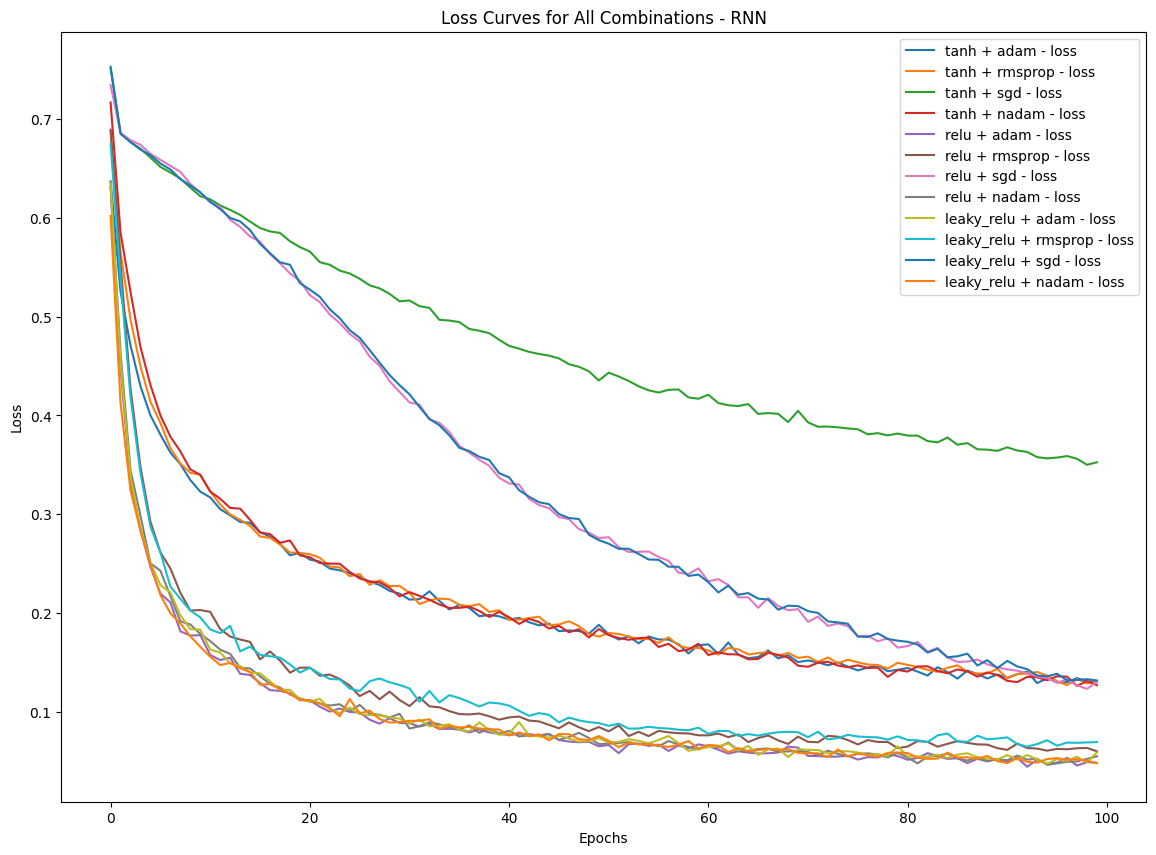

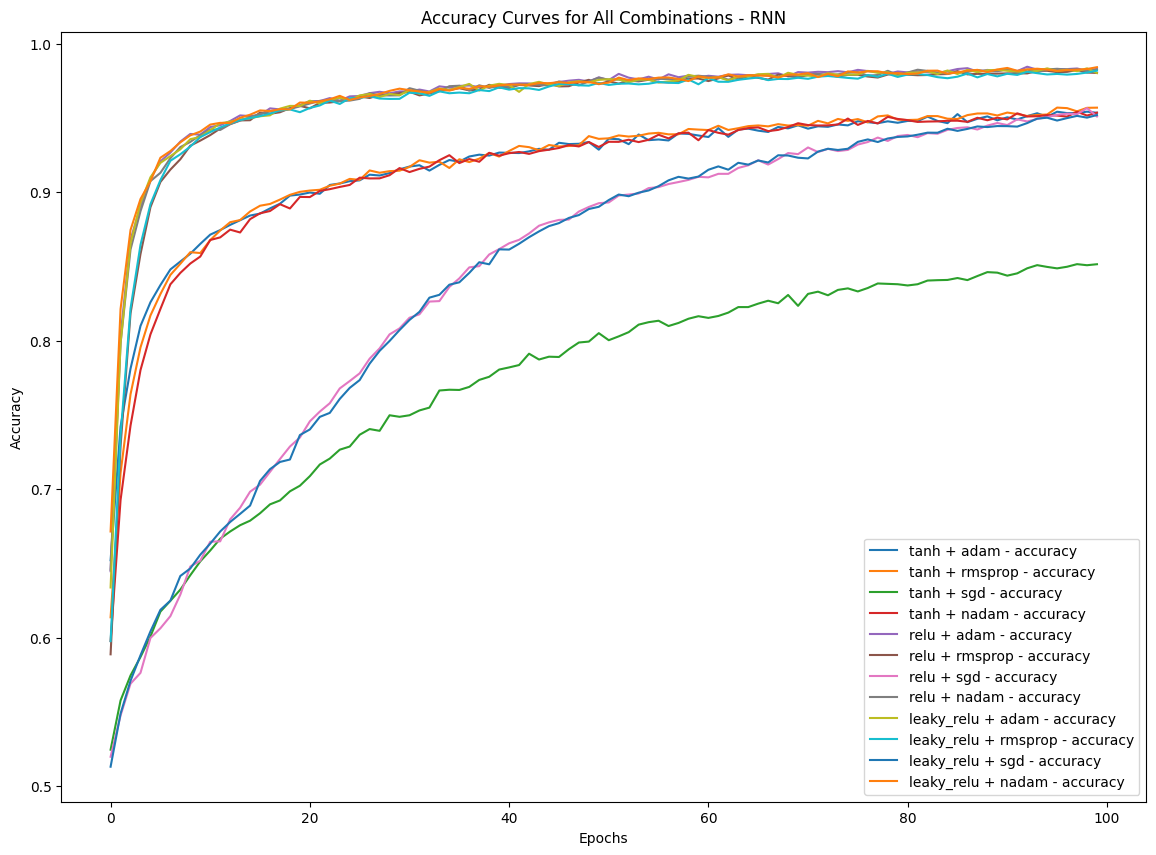

In [21]:
plot_results(histories_rnn, 'RNN')

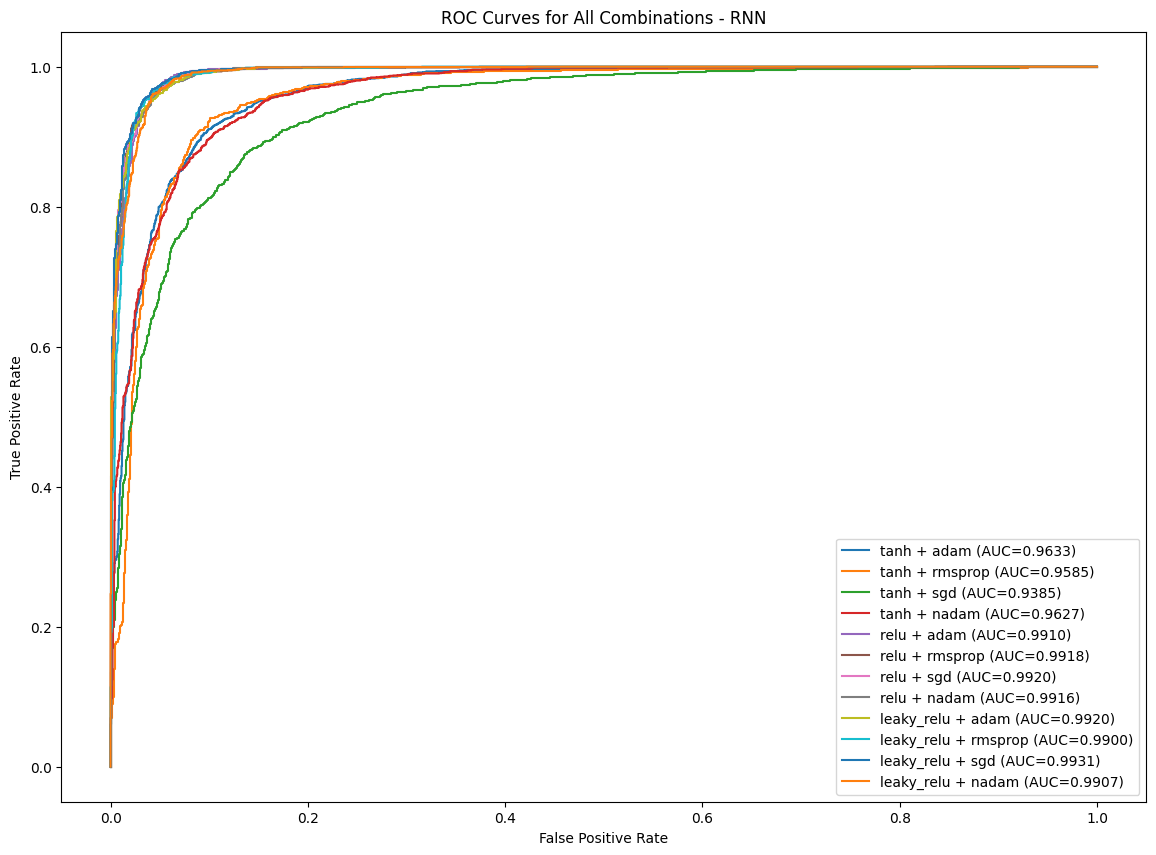

In [22]:
plot_roc_curves(roc_curves_rnn, 'RNN')

In [23]:
best_model_rnn

('leaky_relu', 'sgd')

<h3>LSTM</h3>

In [28]:
# Define the activation functions and optimizers for LSTM
activation_functions_lstm = {
    'tanh' : 'tanh', 
    'sigmoid' : 'sigmoid', 
    'relu' : 'relu'}
optimizers_lstm = {
    'adam': Adam(),
    'rmsprop': RMSprop(),
    'sgd': SGD(),
    'adamw': tfa.optimizers.AdamW(weight_decay=1e-4)
}

In [25]:
def build_lstm_model(input_shape, output_shape, activation, dropout_rate=0.5):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation=activation, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(128, activation=activation)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_shape, activation='sigmoid'))
    return model

In [29]:
# Train and evaluate the LSTM model for each combination
results_lstm = []
histories_lstm = {}
roc_curves_lstm = {}
best_model_lstm = None
best_avg_score = -1

for activation_name, activation in activation_functions_lstm.items():
    for optimizer_name, optimizer in optimizers_lstm.items():
        model = build_lstm_model((X_train.shape[1], X_train.shape[2]), 1, activation)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
        
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
        
        y_pred = model.predict(X_test).ravel()
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes)
        recall = recall_score(y_test, y_pred_classes)
        f1 = f1_score(y_test, y_pred_classes)
        auc = roc_auc_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)

        print(f"Activation: {activation_name}, Optimizer: {optimizer_name}, AUC: {auc:.4f}, AP: {ap:.4f}")
        
        results_lstm.append({
            'Activation Function': activation,
            'Optimizer': optimizer_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'AP': ap,
            'History': history  # Added history to the results dictionary
        })
        histories_lstm[(activation, optimizer_name)] = history
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_curves_lstm[(activation, optimizer_name)] = (fpr, tpr, auc)
        
        # Check for the best model based on average of AUC and AP
        avg_score = np.mean([auc, ap])
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_model_lstm = (activation_name, optimizer_name)

# Print the best model
print(f"\nBest Model: Activation: {best_model_lstm[0]}, Optimizer: {best_model_lstm[1]}")

Epoch 1/100
606/606 [==============================] - 20s 20ms/step - loss: 0.4712 - accuracy: 0.7641 - auc: 0.8539 - val_loss: 0.2134 - val_accuracy: 0.9207 - val_auc: 0.9740
Epoch 2/100
606/606 [==============================] - 13s 21ms/step - loss: 0.2265 - accuracy: 0.9122 - auc: 0.9668 - val_loss: 0.1583 - val_accuracy: 0.9441 - val_auc: 0.9843
Epoch 3/100
606/606 [==============================] - 13s 22ms/step - loss: 0.1585 - accuracy: 0.9394 - auc: 0.9833 - val_loss: 0.1226 - val_accuracy: 0.9564 - val_auc: 0.9894
Epoch 4/100
606/606 [==============================] - 12s 19ms/step - loss: 0.1305 - accuracy: 0.9503 - auc: 0.9885 - val_loss: 0.1227 - val_accuracy: 0.9557 - val_auc: 0.9899
Epoch 5/100
606/606 [==============================] - 14s 23ms/step - loss: 0.1129 - accuracy: 0.9594 - auc: 0.9911 - val_loss: 0.1158 - val_accuracy: 0.9588 - val_auc: 0.9911
Epoch 6/100
606/606 [==============================] - 10s 17ms/step - loss: 0.0948 - accuracy: 0.9651 - auc: 0.993

In [30]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results_lstm, columns=['Activation Function', 'Optimizer', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC','AP'])
results_df

Activation Function Optimizer  Accuracy  Precision    Recall  F1 Score  \
0                 tanh      adam  0.955684   0.930000  0.985549  0.956969   
1                 tanh   rmsprop  0.960983   0.939394  0.985549  0.961918   
2                 tanh       sgd  0.965800   0.942766  0.991811  0.966667   
3                 tanh     adamw  0.958092   0.943150  0.974952  0.958787   
4              sigmoid      adam  0.951108   0.949161  0.953276  0.951214   
5              sigmoid   rmsprop  0.947977   0.930157  0.968690  0.949033   
6              sigmoid       sgd  0.500000   0.500000  1.000000  0.666667   
7              sigmoid     adamw  0.904624   0.895853  0.915703  0.905669   
8                 relu      adam  0.960260   0.951346  0.970135  0.960649   
9                 relu   rmsprop  0.947495   0.912889  0.989403  0.949607   
10                relu       sgd  0.964114   0.940155  0.991329  0.965064   
11                relu     adamw  0.951590   0.931034  0.975434  0.952717   

         AUC        AP  
0   0.991624  0.990536  
1   0.992529  0.990761  
2   0.994125  0.993720  
3   0.990723  0.989490  
4   0.989875  0.988859  
5   0.987596  0.986706  
6   0.512355  0.491777  
7   0.963327  0.958955  
8   0.990463  0.987836  
9   0.977455  0.960688  
10  0.993938  0.993800  
11  0.988657  0.987444

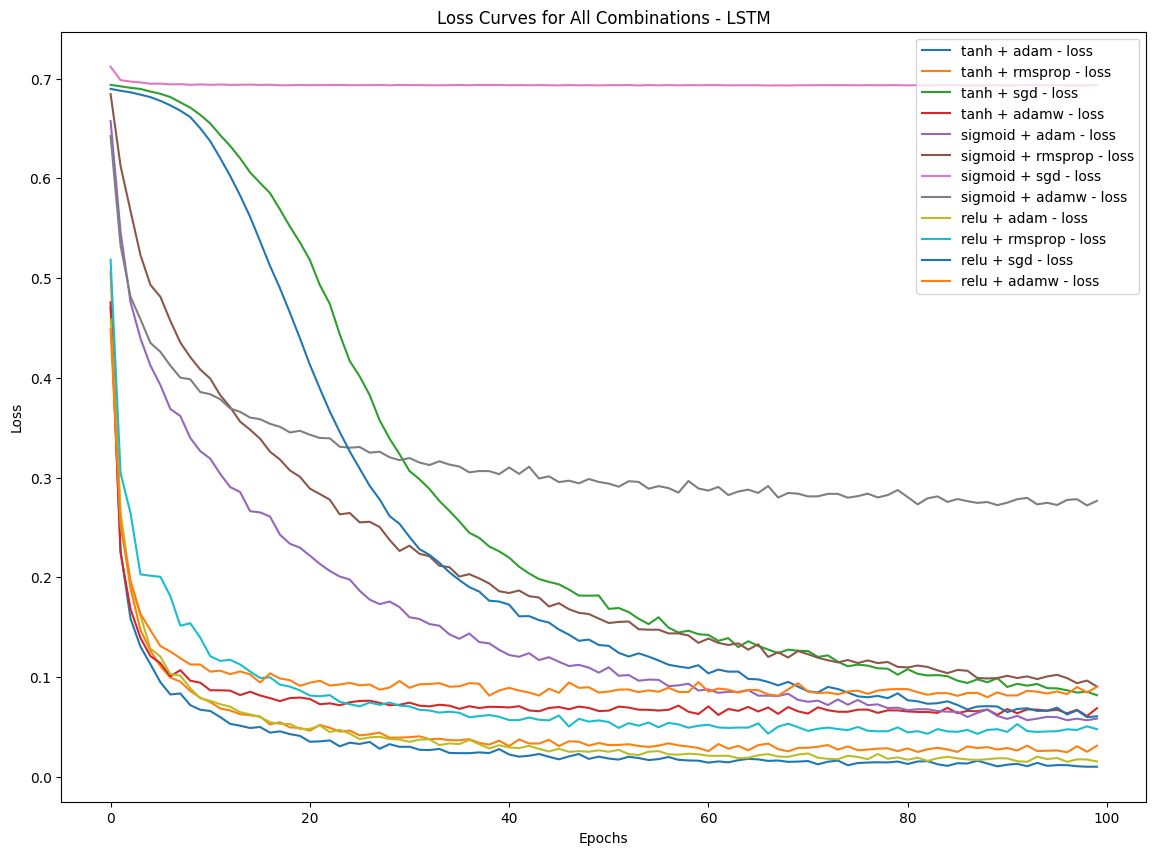

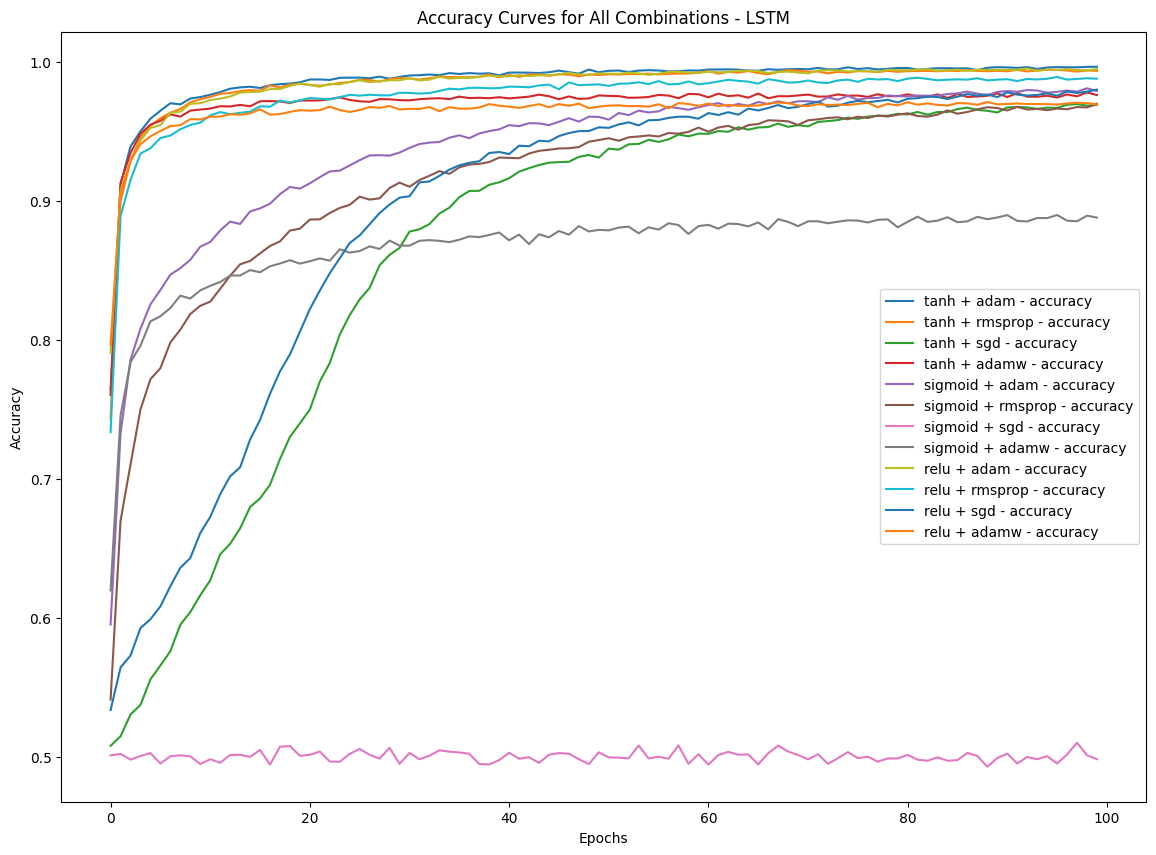

In [31]:
plot_results(histories_lstm, 'LSTM')

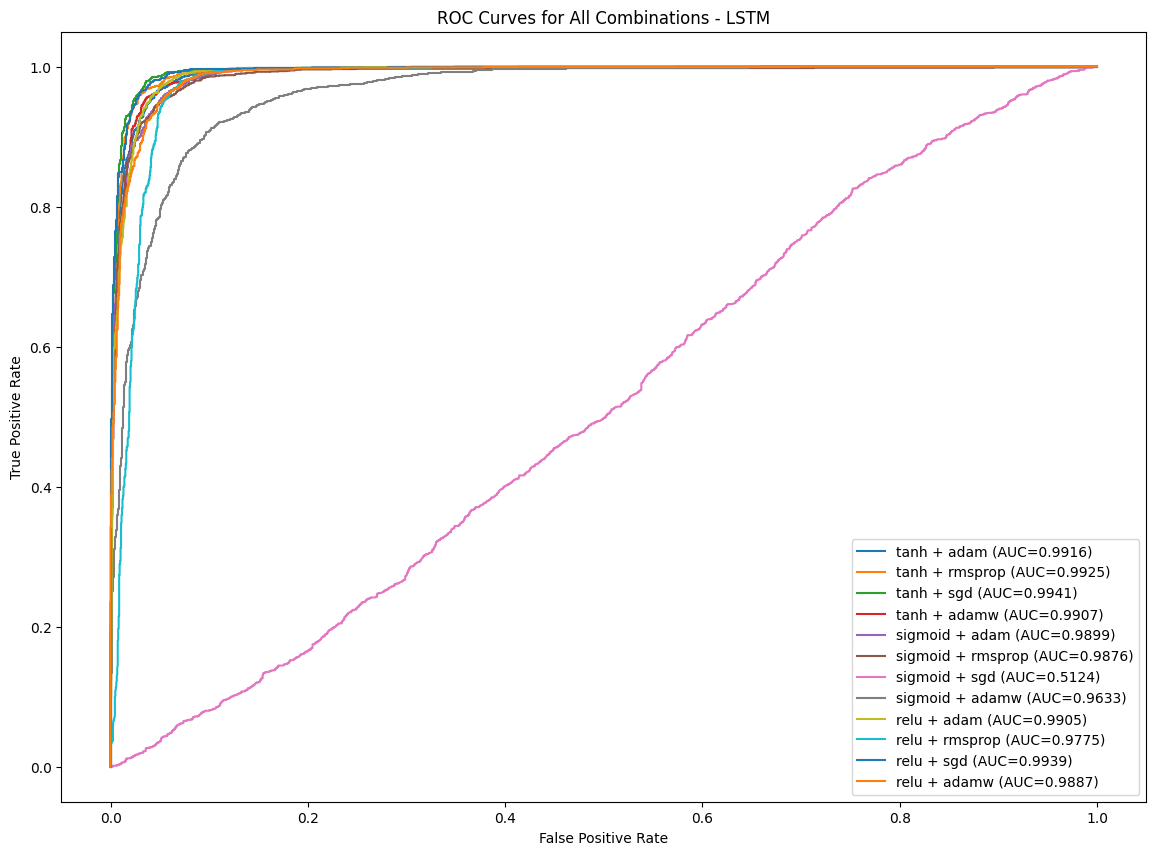

In [32]:
plot_roc_curves(roc_curves_lstm, 'LSTM')

In [33]:
best_model_lstm

('tanh', 'sgd')

<h3>Transformer with Attention</h3>

In [34]:
# Define the activation functions and optimizers for Transformer
activation_functions_transformer = {
    'relu': 'relu',
    'gelu': tf.keras.activations.gelu,
    'swish': tf.keras.activations.swish
}
optimizers_transformer = {
    'adam': Adam(),
    'adamw': tfa.optimizers.AdamW(weight_decay=1e-4),
    'nadam': Nadam(),
    'adagrad': Adagrad()
}

In [35]:
# Define a function to build the Transformer model
def build_transformer_model(input_shape, output_shape, activation, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=8, key_dim=128)(inputs, inputs)
    x = Add()([inputs, x])
    x = LayerNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_shape, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

In [37]:
# Train and evaluate the Transformer model for each combination
results_transformer = []
histories_transformer = {}
roc_curves_transformer = {}
roc_curves_transformer = {}
best_model_transformer = None
best_avg_score = -1

for activation_name, activation in activation_functions_transformer.items():
    for optimizer_name, optimizer in optimizers_transformer.items():
        model = build_transformer_model((X_train.shape[1], X_train.shape[2]), 1, activation)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
        
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, batch_size=32)
        
        y_pred = model.predict(X_test).ravel()
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes)
        recall = recall_score(y_test, y_pred_classes)
        f1 = f1_score(y_test, y_pred_classes)
        auc = roc_auc_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)

        print(f"Activation: {activation_name}, Optimizer: {optimizer_name}, AUC: {auc:.4f}, AP: {ap:.4f}")
        
        results_transformer.append({
            'Activation Function': activation,
            'Optimizer': optimizer_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'AP': ap,
            'History': history  # Added history to the results dictionary
        })
                            
        histories_transformer[(activation_name, optimizer_name)] = history
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_curves_transformer[(activation_name, optimizer_name)] = (fpr, tpr, auc)
        
        # Save history for plotting
        histories_transformer[(activation_name, optimizer_name)] = history

        # Check for the best model based on average of AUC and AP
        avg_score = np.mean([auc, ap])
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_model_transformer = (activation_name, optimizer_name)

# Print the best model
print(f"\nBest Model: Activation: {best_model_transformer[0]}, Optimizer: {best_model_transformer[1]}")

Epoch 1/100
606/606 [==============================] - 5s 6ms/step - loss: 0.5563 - accuracy: 0.7163 - auc: 0.7890 - val_loss: 0.3919 - val_accuracy: 0.8376 - val_auc: 0.9113
Epoch 2/100
606/606 [==============================] - 4s 6ms/step - loss: 0.3976 - accuracy: 0.8272 - auc: 0.9025 - val_loss: 0.3237 - val_accuracy: 0.8711 - val_auc: 0.9445
Epoch 3/100
606/606 [==============================] - 4s 6ms/step - loss: 0.3379 - accuracy: 0.8576 - auc: 0.9298 - val_loss: 0.2818 - val_accuracy: 0.8868 - val_auc: 0.9544
Epoch 4/100
606/606 [==============================] - 4s 6ms/step - loss: 0.3026 - accuracy: 0.8757 - auc: 0.9439 - val_loss: 0.2647 - val_accuracy: 0.8894 - val_auc: 0.9586
Epoch 5/100
606/606 [==============================] - 4s 7ms/step - loss: 0.2780 - accuracy: 0.8876 - auc: 0.9521 - val_loss: 0.2482 - val_accuracy: 0.8993 - val_auc: 0.9625
Epoch 6/100
606/606 [==============================] - 4s 7ms/step - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9587 - val_loss

In [38]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results_transformer, columns=['Activation Function', 'Optimizer', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC','AP'])
results_df

Activation Function Optimizer  Accuracy  Precision  \
0                                     relu      adam  0.933044   0.916204   
1                                     relu     adamw  0.911127   0.905078   
2                                     relu     nadam  0.934730   0.915324   
3                                     relu   adagrad  0.853324   0.829071   
4    <function gelu at 0x000001E9738E00E0>      adam  0.937620   0.925527   
5    <function gelu at 0x000001E9738E00E0>     adamw  0.907033   0.890481   
6    <function gelu at 0x000001E9738E00E0>     nadam  0.932563   0.924386   
7    <function gelu at 0x000001E9738E00E0>   adagrad  0.873073   0.846843   
8   <function swish at 0x000001E9738CFCE0>      adam  0.921724   0.931919   
9   <function swish at 0x000001E9738CFCE0>     adamw  0.895713   0.864302   
10  <function swish at 0x000001E9738CFCE0>     nadam  0.928227   0.922529   
11  <function swish at 0x000001E9738CFCE0>   adagrad  0.861513   0.831639   

      Recall  F1 Score       AUC        AP  
0   0.953276  0.934372  0.977804  0.973296  
1   0.918593  0.911786  0.969684  0.966033  
2   0.958092  0.936220  0.981858  0.978839  
3   0.890173  0.858537  0.928570  0.927926  
4   0.951830  0.938494  0.982857  0.980717  
5   0.928227  0.908962  0.965469  0.960186  
6   0.942197  0.933206  0.979301  0.975306  
7   0.910886  0.877698  0.943394  0.941765  
8   0.909923  0.920790  0.979669  0.976760  
9   0.938825  0.900023  0.957898  0.953919  
10  0.934971  0.928708  0.977628  0.972306  
11  0.906551  0.867481  0.936956  0.936209

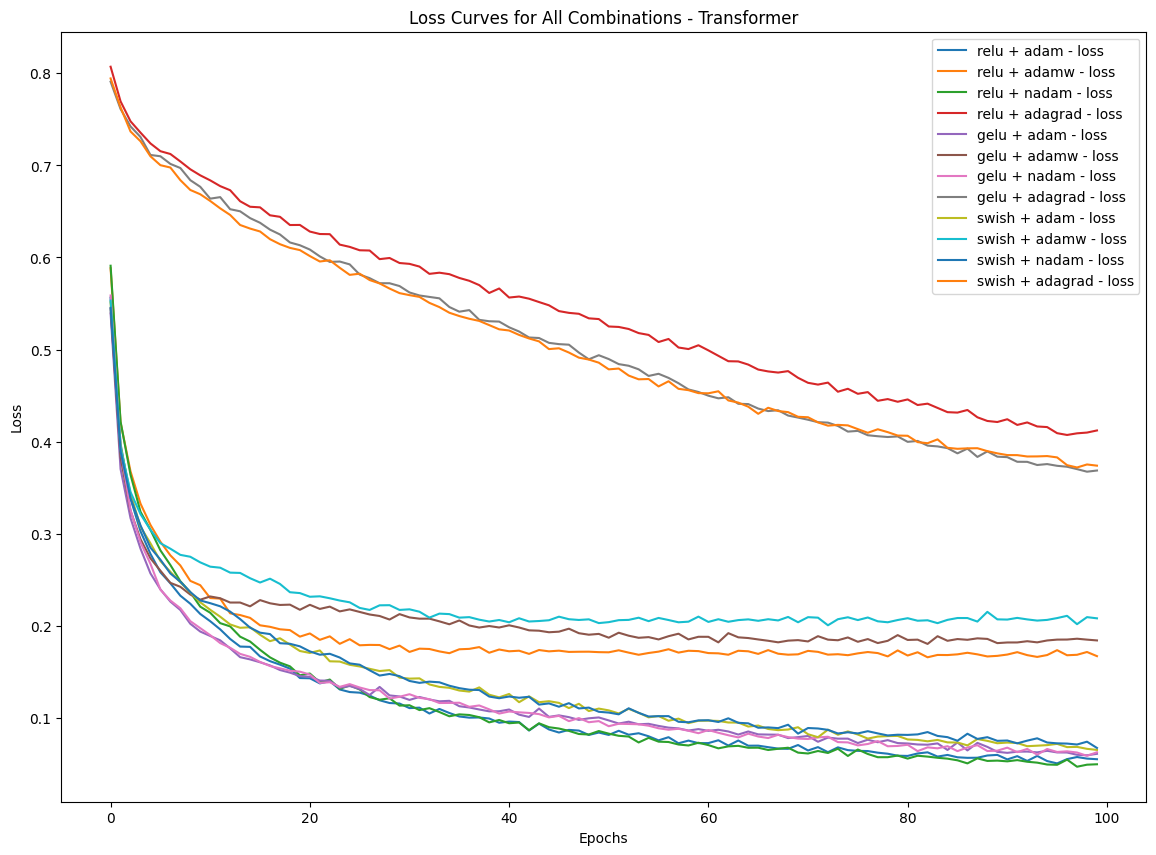

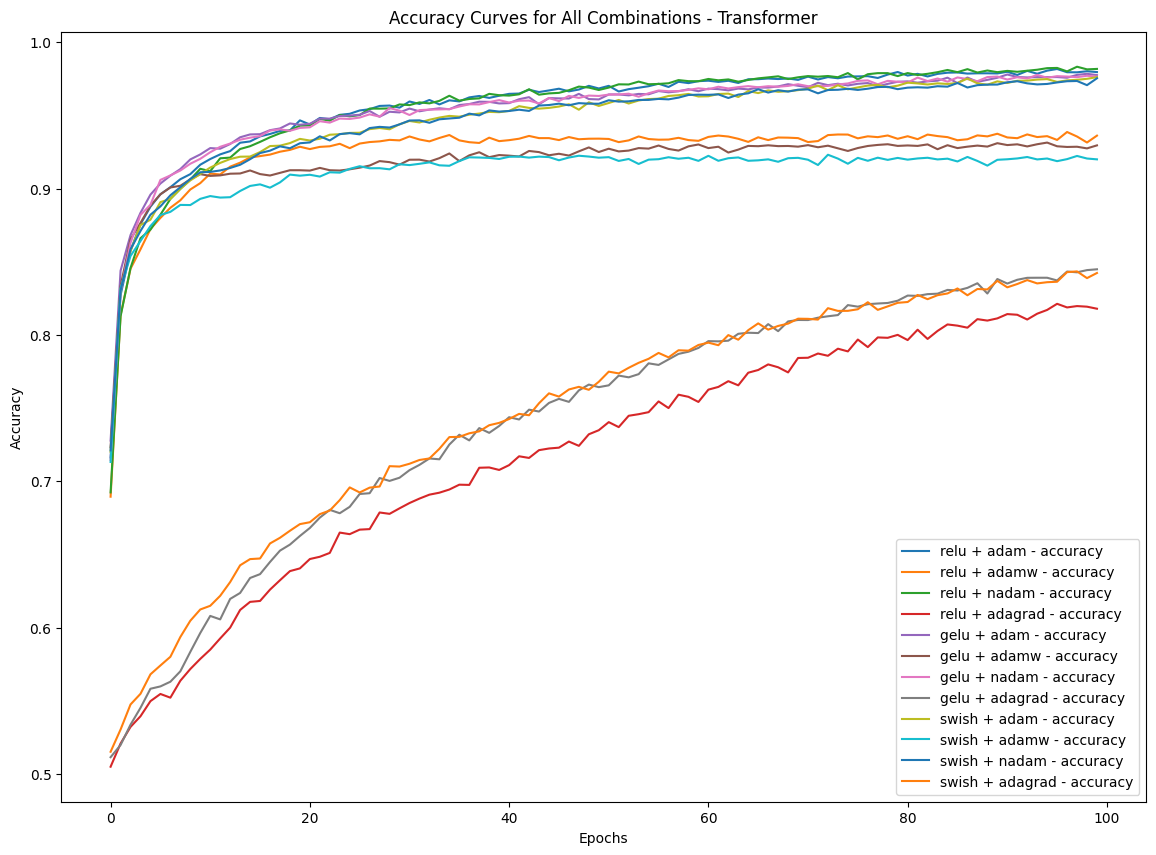

In [39]:
plot_results(histories_transformer, 'Transformer')

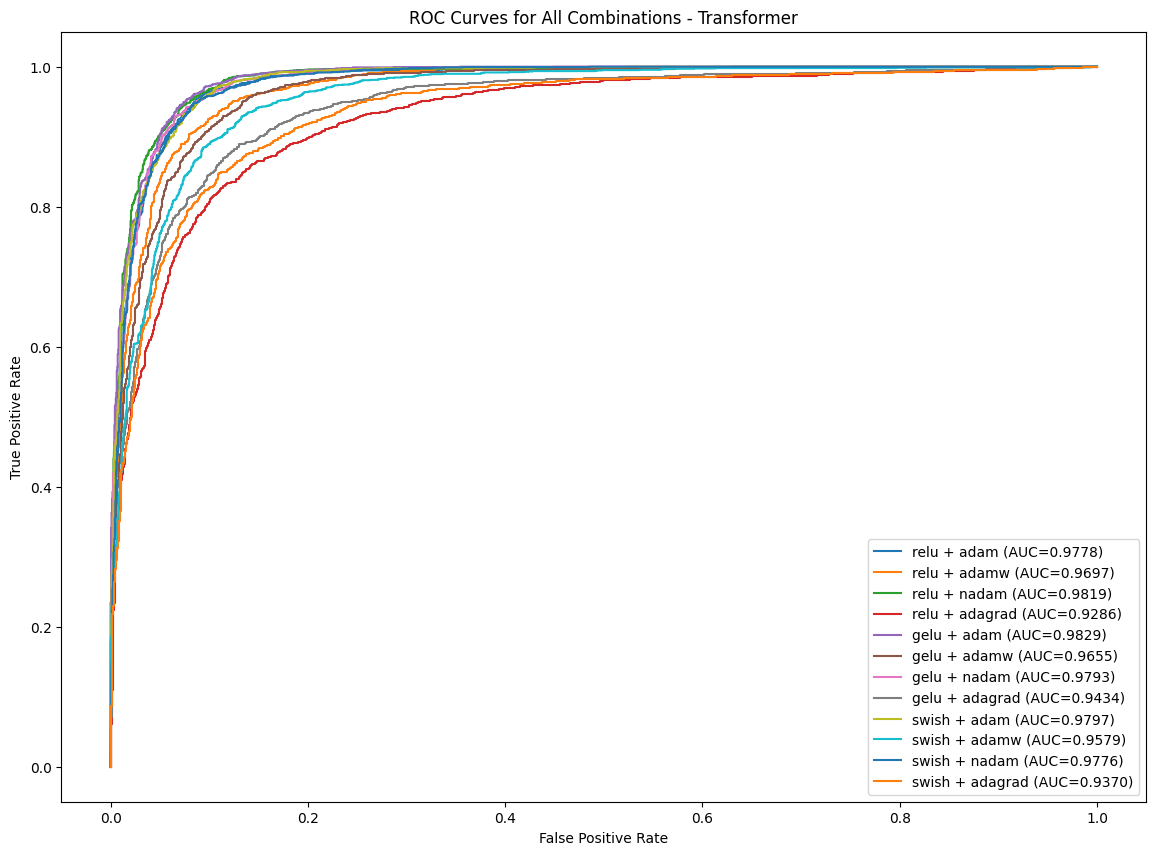

In [40]:
plot_roc_curves(roc_curves_transformer, 'Transformer')

In [41]:
best_model_transformer

('gelu', 'adam')

In [20]:
# Plot learning/loss curves for all combinations
def plot_results(histories, title):
    plt.figure(figsize=(14, 10))
    for (activation, optimizer_name), history in histories.items():
        plt.plot(history.history['loss'], label=f'{activation} + {optimizer_name} - loss')
    plt.title(f'Loss Curves for All Combinations - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 10))
    for (activation, optimizer_name), history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{activation} + {optimizer_name} - accuracy')
    plt.title(f'Accuracy Curves for All Combinations - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot ROC curves for all combinations
def plot_roc_curves(roc_curves, title):
    plt.figure(figsize=(14, 10))
    for (activation, optimizer_name), (fpr, tpr, auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{activation} + {optimizer_name} (AUC={auc:.4f})')
    plt.title(f'ROC Curves for All Combinations - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [ ]:
# Re-train the best RNN model on the full training data
best_activation = best_rnn_model_info[0]
best_optimizer = best_rnn_model_info[1]

best_rnn_model = build_rnn_model((X_train.shape[1], X_train.shape[2]), 1, best_activation)
best_rnn_model.compile(loss='binary_crossentropy', optimizer=optimizers_rnn[best_optimizer], metrics=['accuracy', 'AUC'])
best_rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions with the best RNN model
y_pred = best_rnn_model.predict(X_test).ravel()
y_pred_classes = (y_pred > 0.5).astype(int)

# Print prediction results
print("RNN Model Prediction Results")
for i, (node1, node2) in enumerate(edge_info_test):
    pred_interaction = y_pred_classes[i]
    true_interaction = y_test[i]
    print(f"{node1} | {node2} | {pred_interaction} | {true_interaction}")

# Re-train the best LSTM model on the full training data
best_activation = best_lstm_model_info[0]
best_optimizer = best_lstm_model_info[1]

best_lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), 1, best_activation)
best_lstm_model.compile(loss='binary_crossentropy', optimizer=optimizers_lstm[best_optimizer], metrics=['accuracy', 'AUC'])
best_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions with the best LSTM model
y_pred = best_lstm_model.predict(X_test).ravel()
y_pred_classes = (y_pred > 0.5).astype(int)

# Print prediction results
print("LSTM Model Prediction Results")
for i, (node1, node2) in enumerate(edge_info_test):
    pred_interaction = y_pred_classes[i]
    true_interaction = y_test[i]
    print(f"{node1} | {node2} | {pred_interaction} | {true_interaction}")

# Re-train the best Transformer model on the full training data
best_activation = best_transformer_model_info[0]
best_optimizer = best_transformer_model_info[1]

best_transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]), 1, activation_functions_transformer[best_activation])
best_transformer_model.compile(loss='binary_crossentropy', optimizer=optimizers_transformer[best_optimizer], metrics=['accuracy', 'AUC'])
best_transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions with the best Transformer model
y_pred = best_transformer_model.predict(X_test).ravel()
y_pred_classes = (y_pred > 0.5).astype(int)

# Print prediction results
print("Transformer Model Prediction Results")
for i, (node1, node2) in enumerate(edge_info_test):
    pred_interaction = y_pred_classes[i]
    true_interaction = y_test[i]
    print(f"{node1} | {node2} | {pred_interaction} | {true_interaction}")

Epoch 1/20
692/692 [==============================] - 6s 4ms/step - loss: 0.6778 - accuracy: 0.6038 - auc: 0.6443
Epoch 2/20
692/692 [==============================] - 3s 4ms/step - loss: 0.5205 - accuracy: 0.7528 - auc: 0.8290
Epoch 3/20
692/692 [==============================] - 3s 4ms/step - loss: 0.3943 - accuracy: 0.8346 - auc: 0.9101
Epoch 4/20
692/692 [==============================] - 3s 4ms/step - loss: 0.3066 - accuracy: 0.8811 - auc: 0.9460
Epoch 5/20
692/692 [==============================] - 3s 4ms/step - loss: 0.2788 - accuracy: 0.9010 - auc: 0.9583
Epoch 6/20
692/692 [==============================] - 3s 4ms/step - loss: 0.2435 - accuracy: 0.9154 - auc: 0.9680
Epoch 7/20
692/692 [==============================] - 3s 4ms/step - loss: 0.2361 - accuracy: 0.9230 - auc: 0.9719
Epoch 8/20
692/692 [==============================] - 3s 4ms/step - loss: 0.2223 - accuracy: 0.9291 - auc: 0.9767
Epoch 9/20
692/692 [==============================] - 3s 4ms/step - loss: 0.2045 - accur

In [44]:
# Define the HGNN model
def build_hgnn_model(input_shape, output_shape, activation, dropout_rate=0.5):
    input_layer = Input(shape=input_shape)
    x = Dense(128)(input_layer)
    if activation == 'leaky_relu':
        x = LeakyReLU()(x)
    else:
        x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(output_shape, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [45]:
activations_list = {
    'tanh': 'tanh',
    'relu': 'relu',
    'leaky_relu': LeakyReLU(alpha=0.01)
}
optimizers_dict = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop
}

In [46]:
# Train and evaluate the HGNN model for each combination
results_hgnn = []
histories_hgnn = {}
roc_curves_hgnn = {}
best_model_hgnn = None
best_avg_score = -1

for activation_name, activation in activations_list.items():
    for optimizer_name, optimizer in optimizers_dict.items():
        model = build_hgnn_model(X_train.shape[1:], 1, activation)
        model.compile(loss='binary_crossentropy', optimizer=optimizer(), metrics=['accuracy', 'AUC'])
        
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=100, batch_size=32)
        
        y_pred = model.predict(X_test).ravel()
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes)
        recall = recall_score(y_test, y_pred_classes)
        f1 = f1_score(y_test, y_pred_classes)
        auc = roc_auc_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)

        print(f"Activation: {activation_name}, Optimizer: {optimizer_name}, AUC: {auc:.4f}, AP: {ap:.4f}")
        
        results_hgnn.append({
            'Activation Function': activation,
            'Optimizer': optimizer_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'AP': ap,
            'History': history  # Added history to the results dictionary
        })
        histories_hgnn[(activation, optimizer_name)] = history
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_curves_hgnn[(activation, optimizer_name)] = (fpr, tpr, auc)
        
        # Save history for plotting
        histories_hgnn[(activation, optimizer_name)] = history

        # Check for the best model based on average of AUC and AP
        avg_score = np.mean([auc, ap])
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_model_hgnn = (activation_name, optimizer_name)

# Print the best model
print(f"\nBest Model: Activation: {best_model_hgnn[0]}, Optimizer: {best_model_hgnn[1]}")

Epoch 1/100
606/606 [==============================] - 2s 2ms/step - loss: 0.6631 - accuracy: 0.6187 - auc: 0.6692 - val_loss: 0.5348 - val_accuracy: 0.7430 - val_auc: 0.8309
Epoch 2/100
606/606 [==============================] - 1s 2ms/step - loss: 0.5519 - accuracy: 0.7240 - auc: 0.7935 - val_loss: 0.4541 - val_accuracy: 0.7988 - val_auc: 0.8925
Epoch 3/100
606/606 [==============================] - 1s 2ms/step - loss: 0.4736 - accuracy: 0.7744 - auc: 0.8551 - val_loss: 0.3909 - val_accuracy: 0.8369 - val_auc: 0.9232
Epoch 4/100
606/606 [==============================] - 1s 2ms/step - loss: 0.4287 - accuracy: 0.8059 - auc: 0.8837 - val_loss: 0.3501 - val_accuracy: 0.8615 - val_auc: 0.9383
Epoch 5/100
606/606 [==============================] - 1s 2ms/step - loss: 0.3857 - accuracy: 0.8278 - auc: 0.9082 - val_loss: 0.3316 - val_accuracy: 0.8636 - val_auc: 0.9436
Epoch 6/100
606/606 [==============================] - 1s 2ms/step - loss: 0.3611 - accuracy: 0.8433 - auc: 0.9200 - val_loss

In [47]:
# Convert results to a DataFrame for better visualization
results_df_hgnn = pd.DataFrame(results_hgnn, columns=['Activation Function', 'Optimizer', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC','AP'])
results_df_hgnn

Activation Function Optimizer  Accuracy  \
0                                               tanh      adam  0.909923   
1                                               tanh       sgd  0.876686   
2                                               tanh   rmsprop  0.901012   
3                                               relu      adam  0.952071   
4                                               relu       sgd  0.939547   
5                                               relu   rmsprop  0.957129   
6  <keras.src.layers.activation.leaky_relu.LeakyR...      adam  0.952312   
7  <keras.src.layers.activation.leaky_relu.LeakyR...       sgd  0.946532   
8  <keras.src.layers.activation.leaky_relu.LeakyR...   rmsprop  0.956166   

   Precision    Recall  F1 Score       AUC        AP  
0   0.877886  0.952312  0.913586  0.970428  0.966573  
1   0.810317  0.983622  0.888599  0.966247  0.961175  
2   0.855617  0.964836  0.906950  0.967675  0.964469  
3   0.938347  0.967726  0.952810  0.987906  0.986500  
4   0.897603  0.992293  0.942576  0.989125  0.987280  
5   0.945540  0.970135  0.957680  0.986152  0.981324  
6   0.943343  0.962428  0.952790  0.988723  0.987069  
7   0.908011  0.993738  0.948942  0.990201  0.989416  
8   0.937211  0.977842  0.957096  0.987398  0.983246

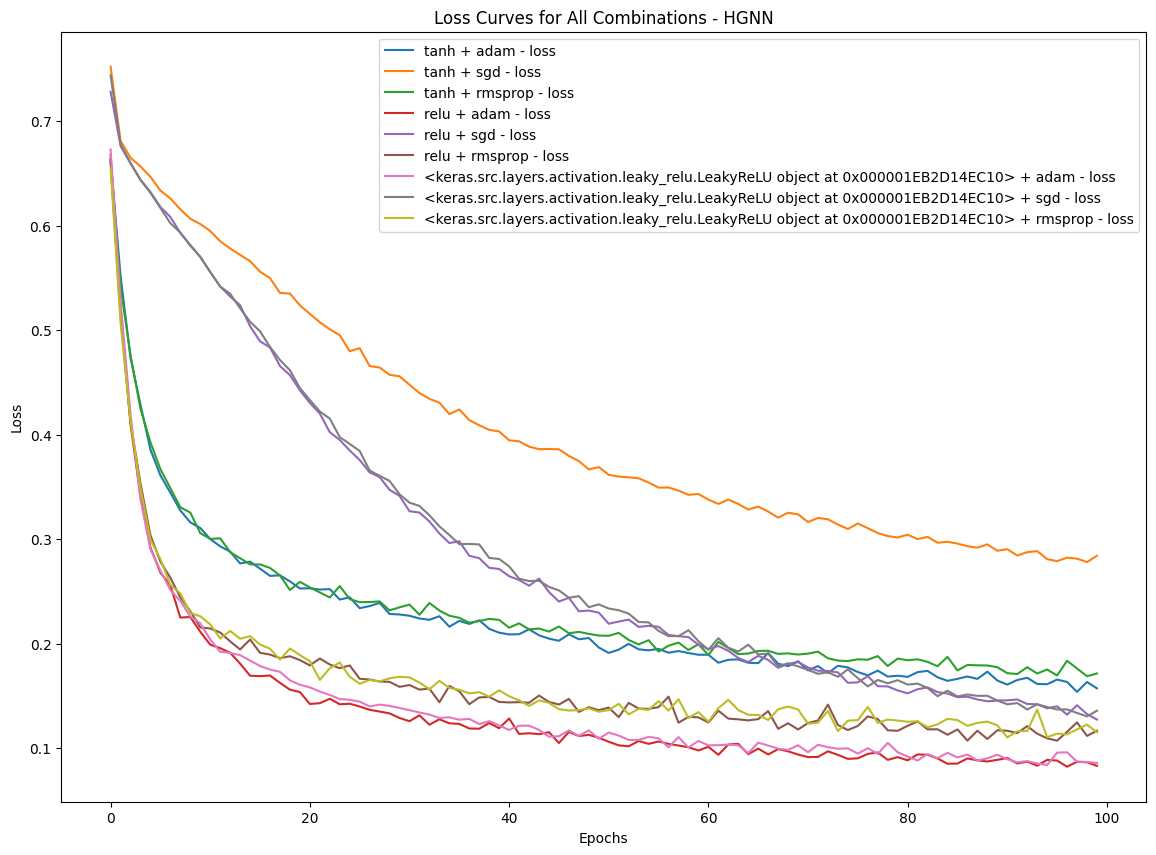

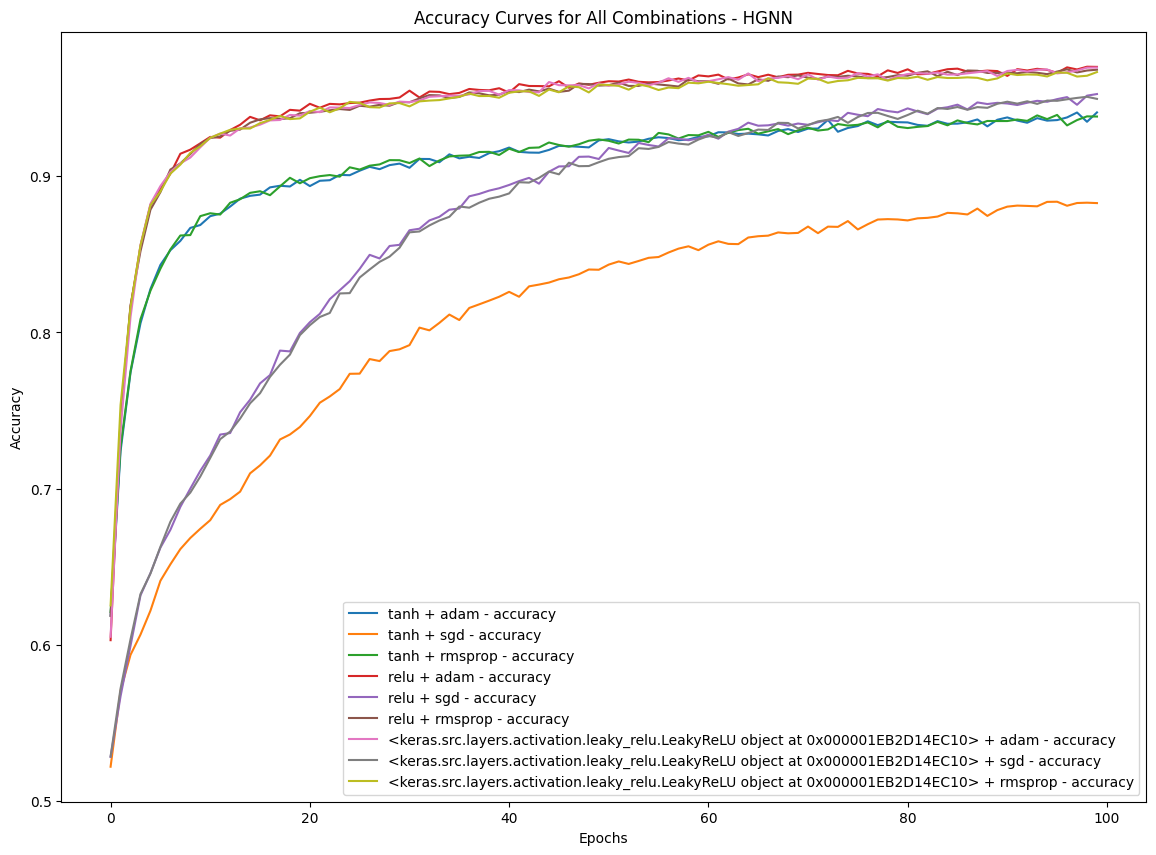

In [48]:
plot_results(histories_hgnn, 'HGNN')

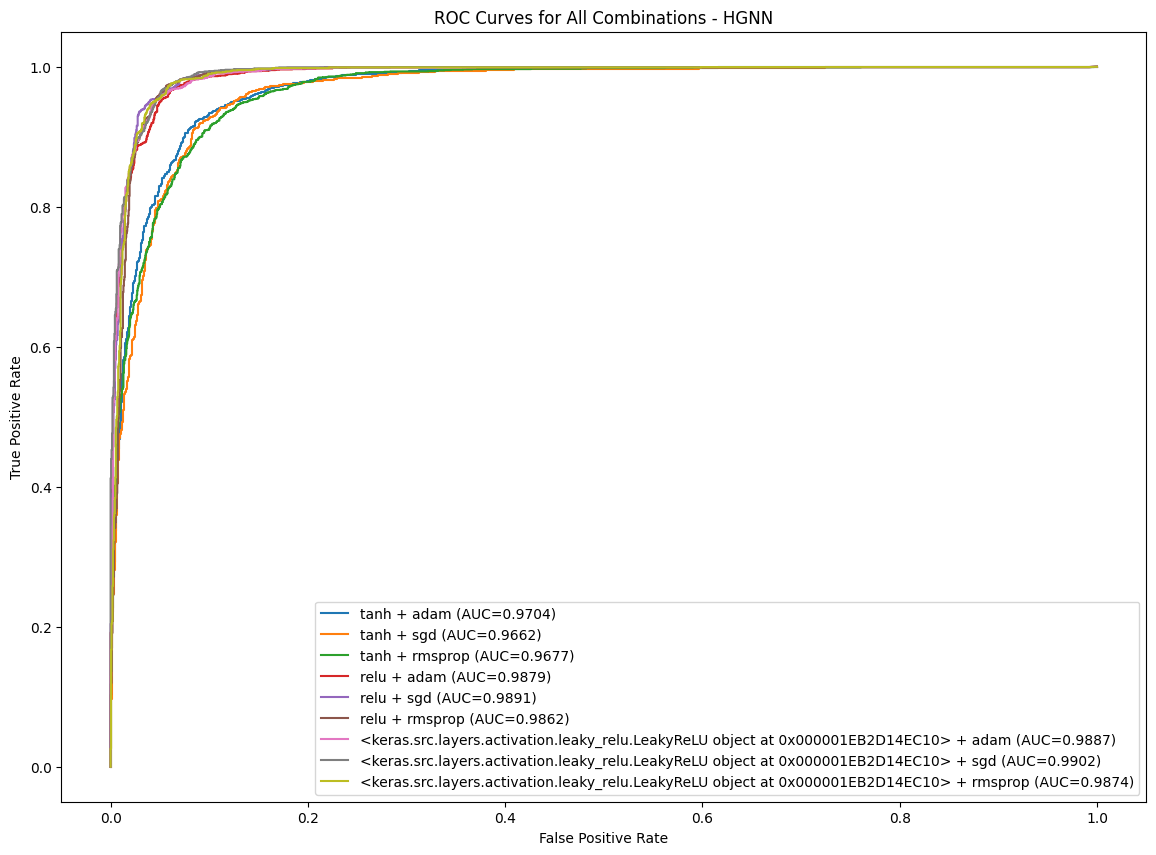

In [49]:
plot_roc_curves(roc_curves_hgnn, 'HGNN')

In [50]:
best_model_hgnn

('leaky_relu', 'sgd')

In [51]:
def choose_best_combination(results):
    best_combination = max(results, key=lambda x: np.mean([x[metric] for metric in ['AUC','AP']]))
    return best_combination

In [52]:
best_combinations_rnn = choose_best_combination(results_rnn)
best_combinations_lstm = choose_best_combination(results_lstm)
best_combinations_transformer = choose_best_combination(results_transformer)
best_combinations_hgnn = choose_best_combination(results_hgnn)

In [54]:
best_models = {
    'RNN': best_combinations_rnn,
    'LSTM': best_combinations_lstm,
    'Transformer': best_combinations_transformer,
    'HGNN' : best_combinations_hgnn
}

In [55]:
best_models

{'RNN': {'Activation Function': 'leaky_relu',
  'Optimizer': 'sgd',
  'Accuracy': 0.9178709055876686,
  'Precision': 0.8598092077975944,
  'Recall': 0.9985549132947977,
  'F1 Score': 0.9240026743926901,
  'AUC': 0.9930653008416215,
  'AP': 0.9923890504804807,
  'History': <keras.src.callbacks.History at 0x1ea6cd6d390>},
 'LSTM': {'Activation Function': 'tanh',
  'Optimizer': 'sgd',
  'Accuracy': 0.9657996146435452,
  'Precision': 0.9427655677655677,
  'Recall': 0.9918111753371869,
  'F1 Score': 0.9666666666666667,
  'AUC': 0.9941254487472202,
  'AP': 0.9937200949919959,
  'History': <keras.src.callbacks.History at 0x1eac3c9da90>},
 'Transformer': {'Activation Function': <function keras.src.activations.gelu(x, approximate=False)>,
  'Optimizer': 'adam',
  'Accuracy': 0.9376204238921002,
  'Precision': 0.9255269320843091,
  'Recall': 0.9518304431599229,
  'F1 Score': 0.93849441937782,
  'AUC': 0.9828574617335102,
  'AP': 0.980717167625148,
  'History': <keras.src.callbacks.History at 0x1

In [56]:
best_overall_model = max(best_models.items(), key=lambda x: np.mean([x[1][metric] for metric in ['AUC','AP']]))

In [57]:
best_overall_model

('LSTM',
 {'Activation Function': 'tanh',
  'Optimizer': 'sgd',
  'Accuracy': 0.9657996146435452,
  'Precision': 0.9427655677655677,
  'Recall': 0.9918111753371869,
  'F1 Score': 0.9666666666666667,
  'AUC': 0.9941254487472202,
  'AP': 0.9937200949919959,
  'History': <keras.src.callbacks.History at 0x1eac3c9da90>})

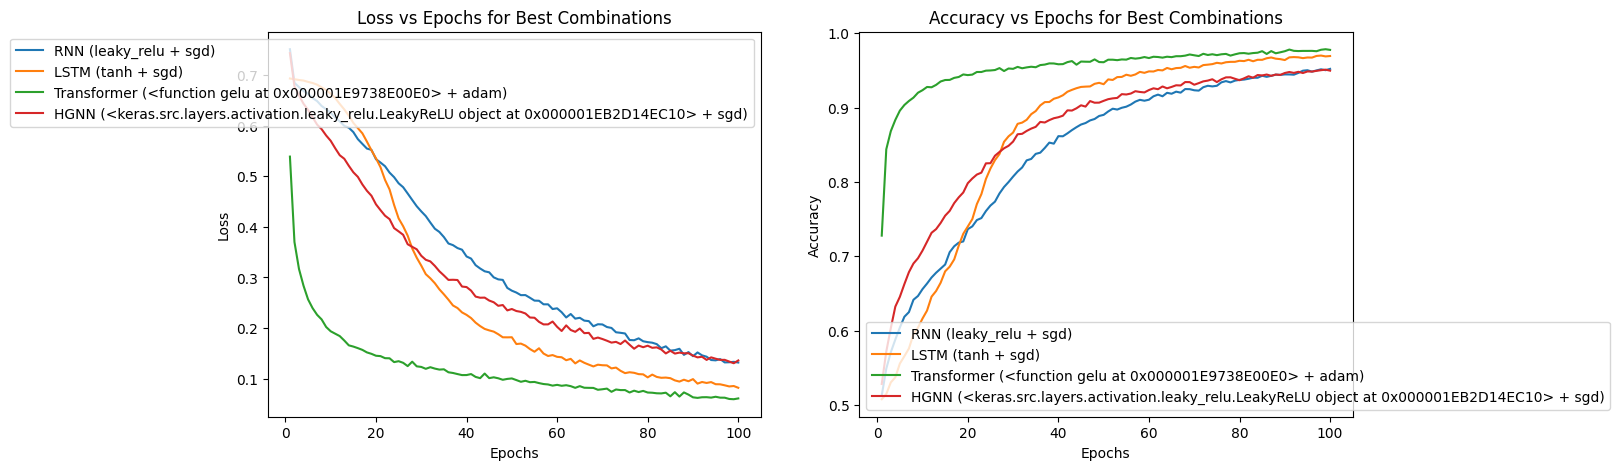

In [61]:
def plot_best_combinations(best_combinations):
    plt.figure(figsize=(14, 5))
    
    for model, best_combination in best_combinations.items():
        history = best_combination['History']
        activation = best_combination['Activation Function']
        optimizer = best_combination['Optimizer']
        epochs = range(1, len(history.history['loss']) + 1)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['loss'], label=f'{model} ({activation} + {optimizer})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs Epochs for Best Combinations')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], label=f'{model} ({activation} + {optimizer})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy vs Epochs for Best Combinations')
        
    plt.savefig(save_path)  # Save the figure to the specified file
    plt.show()

# Call this function after finding the best combinations
plot_best_combinations(best_models)